<a href="https://colab.research.google.com/github/bloodclaw2000/Dementia_OASIS_Saturdays/blob/testing/dementia%20colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forzamos una versión de Python más nueva y clonamos el repositorio de GitHub para los archivos python

In [1]:
%cd /content/
import sys
sys.path.insert(0, '/usr/local/lib/python3.11/dist-packages/') #We need to upgrade Python Client for some reason COLAB is py 3.6

#!python -m pip install --upgrade pip
!git clone --single-branch --branch testing https://github.com/bloodclaw2000/Dementia_OASIS_Saturdays.git

%cd Dementia_OASIS_Saturdays

/content
Cloning into 'Dementia_OASIS_Saturdays'...
remote: Enumerating objects: 1012, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1012 (delta 0), reused 5 (delta 0), pack-reused 1006
Receiving objects: 100% (1012/1012), 839.36 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Updating files: 100% (430/430), done.
/content/Dementia_OASIS_Saturdays


Instalamos Optuna

In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.5 MB/s eta 0:00:00


Importamos las librerias

In [4]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import sys
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import pickle
import _pickle as cPickle
import bz2
import csv
import torch
import torchvision
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
from torchvision import transforms
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
# from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz
from sklearn import tree


Importamos las funciones necesarias desde nuestros programas python

In [27]:
from pickle_aux import pet_load, decompress_pickle, pet_save
from dementia_network_class import Dementia, train_nn, train_nn_auto, getOutput
from dementia_tree_class import train_tree,  Customtree
from hyperparameter_optimization import get_optimal_params, find_hyperparams_optuna, visualizeresults
from functions_transform import fft_transform, border_transform

Generamos las carpetas para guardar las redes neuronales, los datasets y las figuras

In [6]:
def createnecessaryfolders():
    if not os.path.exists(f"plots/"):
        os.makedirs(f"plots/")
    if not os.path.exists(f"studies/"):
        os.makedirs(f"studies/")
    if not os.path.exists(f"params_nn/"):
        os.makedirs(f"params_nn/")
    if not os.path.exists(f"nn/"):
        os.makedirs(f"nn/")
    if not os.path.exists(f"logs/"):
        os.makedirs(f"logs/")
    if not os.path.exists(f"hyperparams/"):
        os.makedirs(f"hyperparams/")
    if not os.path.exists(f"dataset/"):
        os.makedirs(f"dataset/")
    if not os.path.exists(f"params_tree/"):
        os.makedirs(f"params_tree/")
createnecessaryfolders()


**Version 1.9.1 of Project
28/05/2024**


Usamos CPU o GPU dependiendo de lo que haya disponible

In [7]:
torch.multiprocessing.set_start_method('spawn', force=True) #kinda important mostly for CPU

device = torch.device(
                                        f'cuda:{torch.cuda.current_device()}'
                                        if torch.cuda.is_available()
                                        else 'cpu')

Cargamos el diccionario y generamos uno nuevo limpio sin comprimir

In [8]:
compressed_pickle_directory = "save_dict3"
if not os.path.exists('{0}_decompressed.p'.format(compressed_pickle_directory)):
    def force_dementia(dictionary):
              for key in dictionary:
                        for key2 in dictionary[key]:
                            if dictionary[key][key2]['CDR'] == '':
                                      dictionary[key][key2]['Dementia'] = 0
                            elif float(dictionary[key][key2]['CDR']) > 0:
                                      dictionary[key][key2]['Dementia'] = 1
                            else:
                                      dictionary[key][key2]['Dementia'] = 0
              return dictionary

    def removeyoung(dictionary, age):
              dic_pacientes_viejos = {}
              for key in dictionary:
                        for key2 in dictionary[key]:
                            if int(dictionary[key][key2]['Age']) >= age:
                                      dic_pacientes_viejos[key] = dictionary[key]
              return dic_pacientes_viejos

    tmp_dict = decompress_pickle('{0}.pbz2'.format(compressed_pickle_directory))
    tmp_dict = force_dementia(tmp_dict) #esto es la funcion del init
    tmp_dict = removeyoung(tmp_dict, 59)
    tmp_dict = {int(key): value for key, value in tmp_dict.items()}
    new_dict = {}
    current_index = 0
    for key in sorted(tmp_dict.keys()):
                        new_dict[current_index] = tmp_dict[key]
                        current_index += 1
    tmp_dict = new_dict

    pet_save(tmp_dict,'{0}_decompressed.p'.format(compressed_pickle_directory))
else:
     tmp_dict=pet_load('{0}_decompressed.p'.format(compressed_pickle_directory))


El diccionario sigue el siguiente esquema con propiedades para cada sujeto:


In [23]:
print(tmp_dict[1].keys())
print('Tipos de medidas', list(tmp_dict[1]['1'].keys()))
print('FSL FoLDER', tmp_dict[1]['1']['FSL_SEG'].keys())
print('RAW FOlder', tmp_dict[1]['1']['RAW'].keys())
print('FSL FoLDER inside', tmp_dict[1]['1']['FSL_SEG'][1].keys())
print('FSL FoLDER inside array', tmp_dict[1]['1']['FSL_SEG'][1]['original'].shape)
print('Tambien el id esta dentro del diccionario', tmp_dict[1]['1']['ID'])
print('Tipos de medidas', list(tmp_dict[9]['1'].keys()))
print('Tipos de medidas', tmp_dict[9]['1']['CDR'])


dict_keys(['1'])
Tipos de medidas ['FSL_SEG', 'SUBJ_111', 'T88_111', 'RAW', 'ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay', 'Dementia']
FSL FoLDER dict_keys([1])
RAW FOlder dict_keys([1, 2, 3, 4])
FSL FoLDER inside dict_keys(['original'])
FSL FoLDER inside array (208, 176)
Tambien el id esta dentro del diccionario 0003
Tipos de medidas ['FSL_SEG', 'SUBJ_111', 'T88_111', 'RAW', 'ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay', 'Dementia']
Tipos de medidas 0.5


Veamos alguna imagen

<Figure size 640x480 with 0 Axes>

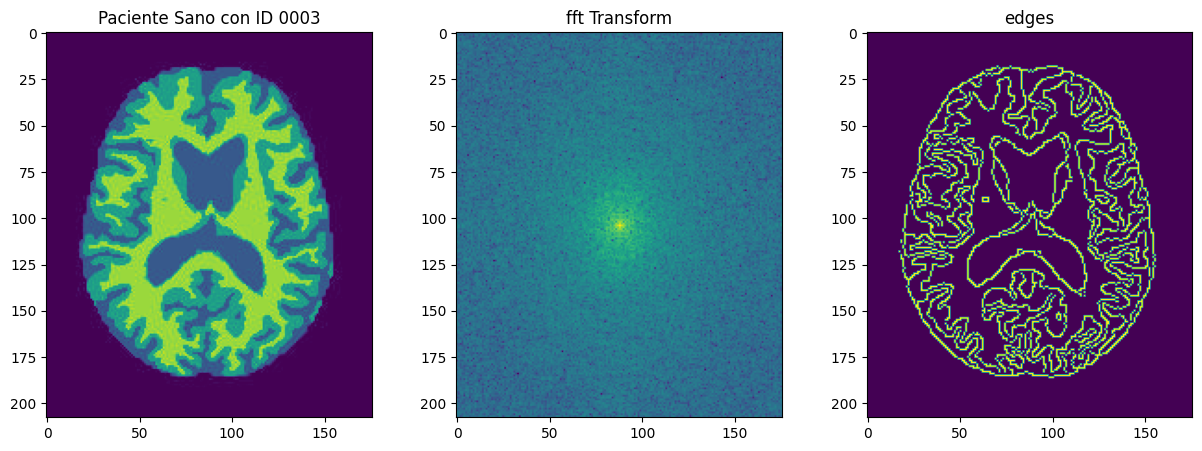

<Figure size 640x480 with 0 Axes>

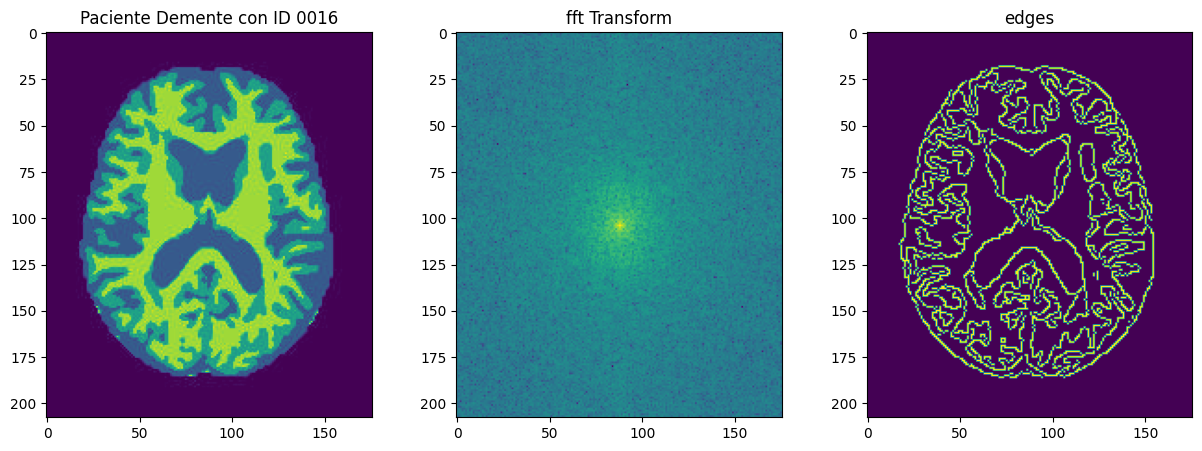

In [30]:
plt.rcdefaults()
image_array = tmp_dict[1]['1']['FSL_SEG'][1]['original']
fft_array = fft_transform(image_array)
edge_array =  border_transform(image_array)

plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image_array)
ax[0].set_title('Original MRI')
ax[1].imshow(fft_array)
ax[1].set_title('fft Transform')
ax[2].imshow(edge_array)
ax[2].set_title('edges')
ax[0].set_title('Paciente Sano con ID '+ tmp_dict[1]['1']['ID'])
plt.show()

image_array = tmp_dict[5]['1']['FSL_SEG'][1]['original']
fft_array = fft_transform(image_array)
edge_array =  border_transform(image_array)

plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image_array)
ax[0].set_title('Original MRI',)
ax[1].imshow(fft_array)
ax[1].set_title('fft Transform')
ax[2].imshow(edge_array)
ax[2].set_title('edges')
ax[0].set_title('Paciente Demente con ID ' + tmp_dict[5]['1']['ID'])
plt.show()

Forzamos el device y generamos un objeto de todas las redes neuronales

In [31]:
torch.set_default_device(device)

print(f" Using {device} in this run")

logpath = 'logs/'
obj = Dementia(dictionary=tmp_dict, device=device)


 Using cuda:0 in this run
56969044


Seteamos los parámetros manualmente que queramos, también hay archivos txt en params

In [32]:
#Podemos setear los parámetros para el entrenamiento aquí:
obj.setParam('image_type','T88_111')
obj.setParam('image_number',1)


Entrenamos la optimizacion de hiperparametros con Optuna así

In [33]:
if os.path.exists('tmp_nn.p'):
    obj = pet_load('tmp_nn.p')
    print(f"USing old unfinished dataset split with seed {obj.seed}")
#find_hyperparams_optuna(obj, 'params_nn/','hyperparams/','studies/','dataset/', ['RAW_1','RAW_2','RAW_3','T88'],logpath = logpath, n_trials= 200)


Y visualizamos los resultados de un estudio


Best trial until now:
 Value:  3.1934394428390077e-06
 Params: 
    patience_validation: 2
    patience_plateau: 0. 3
    delta_min: 0.1
    batch_size: 40
    split_size: 0.75
    max_loss_reset: 1
    learning_rate: 9.249586951612229e-05
    weight_decay: 0.016307327972906644
    first_conv_outchann: 10
    second_conv_outchann: 24
    fclayer1: 210
    fclayer2: 0
Best parameters: {'patience_validation': 2, 'patience_plateau': '0. 3', 'delta_min': '0.1', 'batch_size': 40, 'split_size': 0.75, 'max_loss_reset': 1, 'learning_rate': 9.249586951612229e-05, 'weight_decay': 0.016307327972906644, 'first_conv_outchann': 10, 'second_conv_outchann': 24, 'fclayer1': 210, 'fclayer2': 0}
Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  0
  Number of complete trials:  199
Best Trials [FrozenTrial(number=82, state=TrialState.COMPLETE, values=[3.1934394428390077e-06], datetime_start=datetime.datetime(2024, 6, 5, 20, 12, 15, 361998), datetime_complete=datetime.datetime

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:324: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optimization_history = optuna.visualization.matplotlib.plot_optimization_history(study)


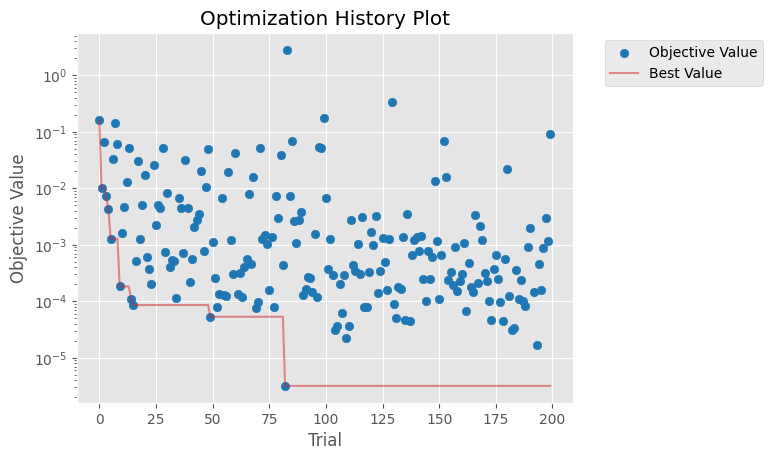

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:329: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  param_importances =  optuna.visualization.matplotlib.plot_param_importances(study)


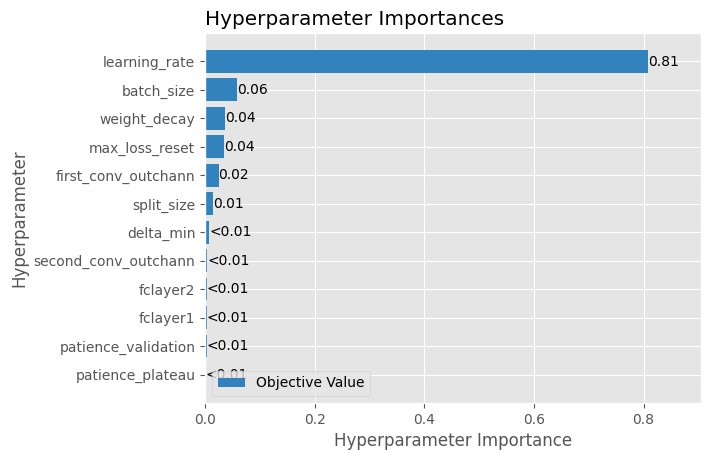

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:334: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  parallel_coordinate =  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


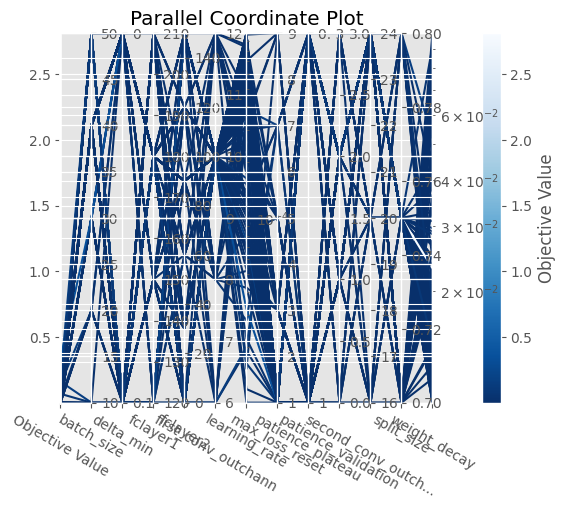

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:339: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  slice_plot =  optuna.visualization.matplotlib.plot_slice(study)


In [ ]:
visualizeresults('studies/RAW_1.pbz2')


Podemos elegir rangos de parámetros para una optimización en bruto con trainn_auto

In [12]:

parameter_ranges_FSL = {
    'patience_validation': [1],
    'patience_plateau': [0],
    'delta_min': [0.1],
    'batch_size': [30, 40, 50],
    'split_size': [0.8],
    'max_loss_reset': [1],
    'learning_rate': [0.00001,0.00005, 0.00008,0.0001],
    'weight_decay': [0.03, 0.01, 0.02],
    'first_conv_outchann': [10,12],
    'second_conv_outchann': [24],
    'fclayer1': [210],
    'fclayer2': ['None'],
    'optimizer': ['Adam']
}
parameter_ranges_T88 = {
    'patience_validation': [0],
    'patience_plateau': [1],
    'delta_min': [0.1],
    'batch_size': [30, 40, 50],
    'split_size': [0.8],
    'max_loss_reset': [1],
    'learning_rate': [0.001,0.0009, 0.0012,0.0015],
    'weight_decay': [0.008, 0.01, 0.02],
    'first_conv_outchann': [12],
    'second_conv_outchann': [20],
    'fclayer1': [180],
    'fclayer2': [30],
    'optimizer': ['Adam']
}
parameter_ranges_RAW_1 = {
    'patience_validation': [2],
    'patience_plateau': [0],
    'delta_min': [0.1],
    'batch_size': [30, 40, 50],
    'split_size': [0.8],
    'max_loss_reset': [1],
    'learning_rate': [0.00012,0.00005, 0.00008,0.0001],
    'weight_decay': [0.016],
    'first_conv_outchann': [10,12],
    'second_conv_outchann': [24],
    'fclayer1': [210],
    'fclayer2': ['None'],
    'optimizer': ['Adam']
}
parameter_ranges_RAW_2 = {
    'patience_validation': [1],
    'patience_plateau': [1],
    'delta_min': [0.1],
    'batch_size': [30, 40, 50],
    'split_size': [0.8],
    'max_loss_reset': [1],
    'learning_rate': [0.0001,0.0005, 0.0002,0.0003],
    'weight_decay': [0.03, 0.01, 0.02],
    'first_conv_outchann': [10,12],
    'second_conv_outchann': [24],
    'fclayer1': [210],
    'fclayer2': ['None'],
    'optimizer': ['Adam']
}
parameter_ranges_RAW_3 = {
    'patience_validation': [1],
    'patience_plateau': [0],
    'delta_min': [0.1],
    'batch_size': [30, 40, 50],
    'split_size': [0.8],
    'max_loss_reset': [1],
    'learning_rate': [0.00001,0.00005, 0.00008,0.0001],
    'weight_decay': [0.03, 0.01, 0.02],
    'first_conv_outchann': [10,12],
    'second_conv_outchann': [24],
    'fclayer1': [210],
    'fclayer2': ['None'],
    'optimizer': ['Adam']
}


In [ ]:
#hyperoptimize from parameter_ranges

#train_nn_auto(obj, 'params_nn/', ['T88'],logpath = logpath,experiments=parameter_ranges_T88,max_iterations_ximage=100)
#train_nn_auto(obj, 'params_nn/', ['RAW_1'],logpath = logpath,experiments=parameter_ranges_RAW_1,max_iterations_ximage=100)
#train_nn_auto(obj, 'params_nn/', ['RAW_2'],logpath = logpath,experiments=parameter_ranges_RAW_2,max_iterations_ximage=100)
#train_nn_auto(obj, 'params_nn/', ['RAW_3'],logpath = logpath,experiments=parameter_ranges_RAW_3,max_iterations_ximage=100)
#train_nn_auto(obj, 'params_nn/', ['FSL'],logpath = logpath,experiments=parameter_ranges_FSL,max_iterations_ximage=100)


Entrenamos cada red neuronal con el tipo de imagenes que queramos y creamos los datasets

In [ ]:
# train(obj,'params/',['T88'])
# train(obj,'params/',['T88','FSL'])
train_nn(obj, 'params_nn/', ['T88', 'FSL', 'RAW_1', 'RAW_2', 'RAW_3'],logpath = logpath)

# getOutput('nn/',['T88'])
# getOutput('nn/',['T88','FSL'])
getOutput('nn/', ['T88', 'FSL', 'RAW_1', 'RAW_2', 'RAW_3'],device = device)


Ahora entrenamos el random_forest

In [ ]:

source_df = pd.read_csv('results.csv')
treeclass = Customtree(source_df)
#treeclass.write_dict_to_file('params_tree/treeparam.txt')
train_tree(treeclass,'params_tree/treeparam.txt')
